## Проверка гипотезы о нормальности распределения в Python

Многие статистические методы (t-тесты, ANOVA, линейная регрессия) предполагают, что данные распределены нормально. Перед применением этих методов необходимо проверить это предположение.

**Существует два подхода к проверке нормальности:**
1. **Визуальные методы** — графический анализ формы распределения
2. **Статистические тесты** — формальная проверка с помощью критериев

Рекомендуется использовать оба подхода в комплексе.

In [3]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки отображения графиков
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Установка seed для воспроизводимости результатов
rng = np.random.default_rng(42)

### Создание тестовых данных

Для демонстрации создадим три набора данных:
- **Нормальное распределение** — данные, которые должны пройти тесты
- **Скошенное распределение** — экспоненциальное (правая асимметрия)
- **Бимодальное распределение** — смесь двух нормальных распределений

In [4]:
# Размер выборки
n = 500

# 1. Нормальное распределение (среднее=100, стд.откл.=15)
data_normal = rng.normal(loc=100, scale=15, size=n)

# 2. Скошенное распределение (экспоненциальное, сдвинутое)
data_skewed = rng.exponential(scale=20, size=n) + 50

# 3. Бимодальное распределение (смесь двух нормальных)
data_bimodal = np.concatenate([
    rng.normal(loc=70, scale=10, size=n//2),
    rng.normal(loc=130, scale=10, size=n//2)
])

# Создадим DataFrame для удобства работы
df = pd.DataFrame({
    'Нормальное': data_normal,
    'Скошенное': data_skewed,
    'Бимодальное': data_bimodal
})

print("Описательная статистика:")
print(df.describe().round(2))

Описательная статистика:
       Нормальное  Скошенное  Бимодальное
count      500.00     500.00       500.00
mean        99.80      70.49        99.97
std         14.40      21.23        31.75
min         61.50      50.02        43.48
25%         90.00      55.93        70.01
50%        100.05      63.68        99.27
75%        108.81      78.62       130.44
max        143.71     199.41       157.11


# ЧАСТЬ 1: ВИЗУАЛЬНЫЕ МЕТОДЫ

Визуальные методы позволяют быстро оценить форму распределения и выявить
очевидные отклонения от нормальности. Они особенно полезны для понимания
**характера** отклонения (асимметрия, тяжёлые хвосты, выбросы).

## 1.1 Гистограмма с кривой нормального распределения

**Суть метода:** строим гистограмму данных и накладываем теоретическую кривую нормального распределения с теми же параметрами (среднее и стд. откл.).

**На что смотреть:**
- Симметричность распределения относительно среднего
- Колоколообразная форма
- Соответствие гистограммы теоретической кривой

**Ограничения:**
- Внешний вид зависит от количества бинов (столбцов)
- Субъективная оценка

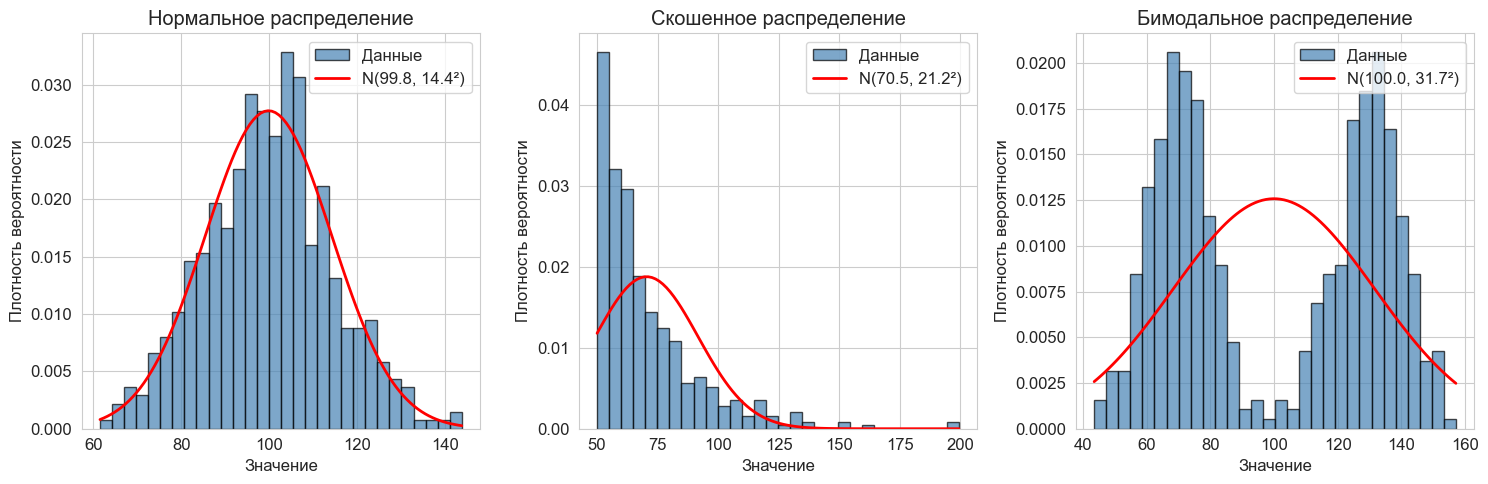

In [5]:
def plot_histogram_with_normal(data, title, ax):
    """
    Строит гистограмму с наложенной кривой нормального распределения.
    
    Параметры:
    ----------
    data : array-like
        Данные для построения гистограммы
    title : str
        Заголовок графика
    ax : matplotlib.axes.Axes
        Объект осей для построения
    """
    # Гистограмма с плотностью вероятности
    ax.hist(data, bins=30, density=True, alpha=0.7, 
            color='steelblue', edgecolor='black', label='Данные')
    
    # Параметры для теоретической кривой
    mu = np.mean(data)
    sigma = np.std(data)
    
    # Теоретическая кривая нормального распределения
    x = np.linspace(data.min(), data.max(), 100)
    y = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', linewidth=2, label=f'N({mu:.1f}, {sigma:.1f}²)')
    
    ax.set_title(title)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Плотность вероятности')
    ax.legend()


# Построение гистограмм для всех трёх распределений
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_histogram_with_normal(data_normal, 'Нормальное распределение', axes[0])
plot_histogram_with_normal(data_skewed, 'Скошенное распределение', axes[1])
plot_histogram_with_normal(data_bimodal, 'Бимодальное распределение', axes[2])

plt.tight_layout()
plt.show()

**Интерпретация:**
- Левый график: гистограмма хорошо соответствует теоретической кривой
- Центральный график: явная правая асимметрия, пик смещён влево
- Правый график: два явных пика, нормальное распределение не подходит

## 1.2 Q-Q Plot (Квантиль-квантильный график)

**Суть метода:** сравниваем квантили наших данных с теоретическими квантилями нормального распределения. Если данные нормально распределены, точки должны лежать приблизительно на прямой линии.

**На что смотреть:**
- Точки на диагональной линии → нормальное распределение
- S-образная кривая → скошенность (асимметрия)
- Отклонения на концах → тяжёлые/лёгкие хвосты
- Отдельные точки далеко от линии → выбросы

**Преимущества:**
- Самый информативный визуальный метод
- Показывает характер отклонения от нормальности
- Не зависит от выбора бинов (как гистограмма)

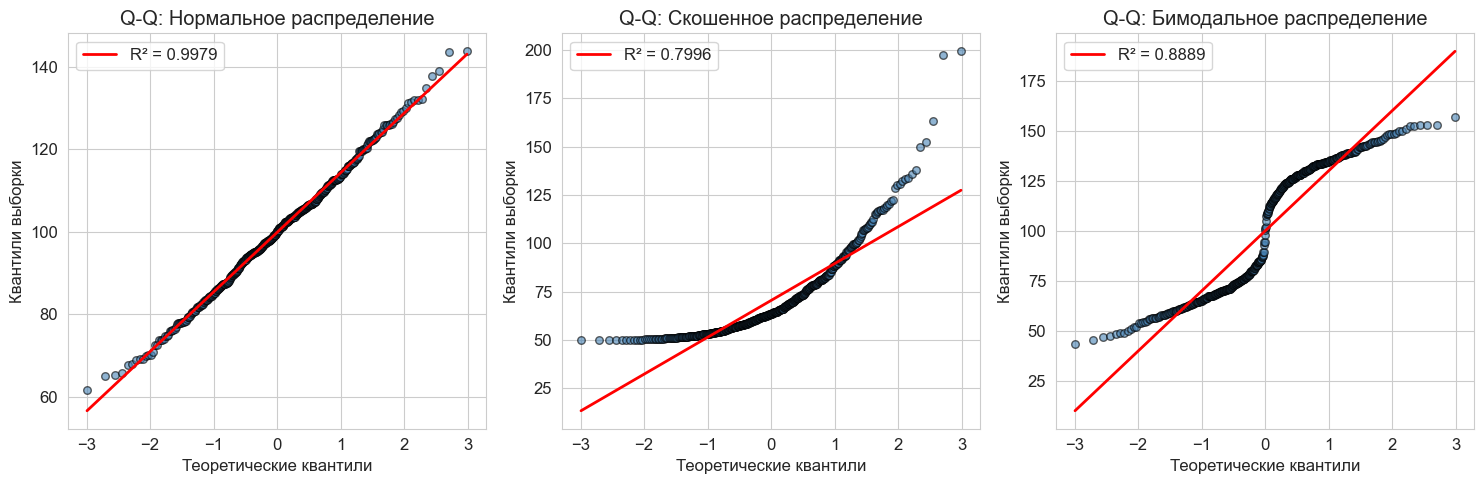

In [6]:
def plot_qq(data, title, ax):
    """
    Строит Q-Q plot для проверки нормальности.
    
    Параметры:
    ----------
    data : array-like
        Данные для анализа
    title : str
        Заголовок графика
    ax : matplotlib.axes.Axes
        Объект осей для построения
    """
    # probplot возвращает координаты точек и параметры линии регрессии
    (theoretical_quantiles, ordered_values), (slope, intercept, r) = stats.probplot(data)
    
    # Точки Q-Q plot
    ax.scatter(theoretical_quantiles, ordered_values, alpha=0.6, 
               color='steelblue', edgecolor='black', s=30)
    
    # Линия идеального соответствия
    line_x = np.array([theoretical_quantiles.min(), theoretical_quantiles.max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r-', linewidth=2, label=f'R² = {r**2:.4f}')
    
    ax.set_title(title)
    ax.set_xlabel('Теоретические квантили')
    ax.set_ylabel('Квантили выборки')
    ax.legend(loc='upper left')


# Построение Q-Q plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_qq(data_normal, 'Q-Q: Нормальное распределение', axes[0])
plot_qq(data_skewed, 'Q-Q: Скошенное распределение', axes[1])
plot_qq(data_bimodal, 'Q-Q: Бимодальное распределение', axes[2])

plt.tight_layout()
plt.show()

**Интерпретация Q-Q plot:**

| Паттерн на графике | Что это означает |
|---|---|
| Точки на прямой линии | Нормальное распределение |
| Точки выгибаются вверх справа | Правая асимметрия (положительная скошенность) |
| Точки выгибаются вниз слева | Левая асимметрия (отрицательная скошенность) |
| S-образная кривая | Тяжёлые хвосты (больше экстремальных значений) |
| Обратная S-образная кривая | Лёгкие хвосты (меньше экстремальных значений) |
| Ступенчатый паттерн | Дискретные данные или округление |

## 1.3 P-P Plot (Вероятность-вероятность график)

**Суть метода:** сравниваем кумулятивные вероятности (CDF) наблюдаемых данных с теоретическими кумулятивными вероятностями нормального распределения.

**Отличие от Q-Q plot:**
- Q-Q plot чувствителен к отклонениям в хвостах распределения
- P-P plot более чувствителен к отклонениям в центре распределения

**Когда использовать:**
- Когда важнее точность в центральной части распределения
- Для сравнения нескольких распределений

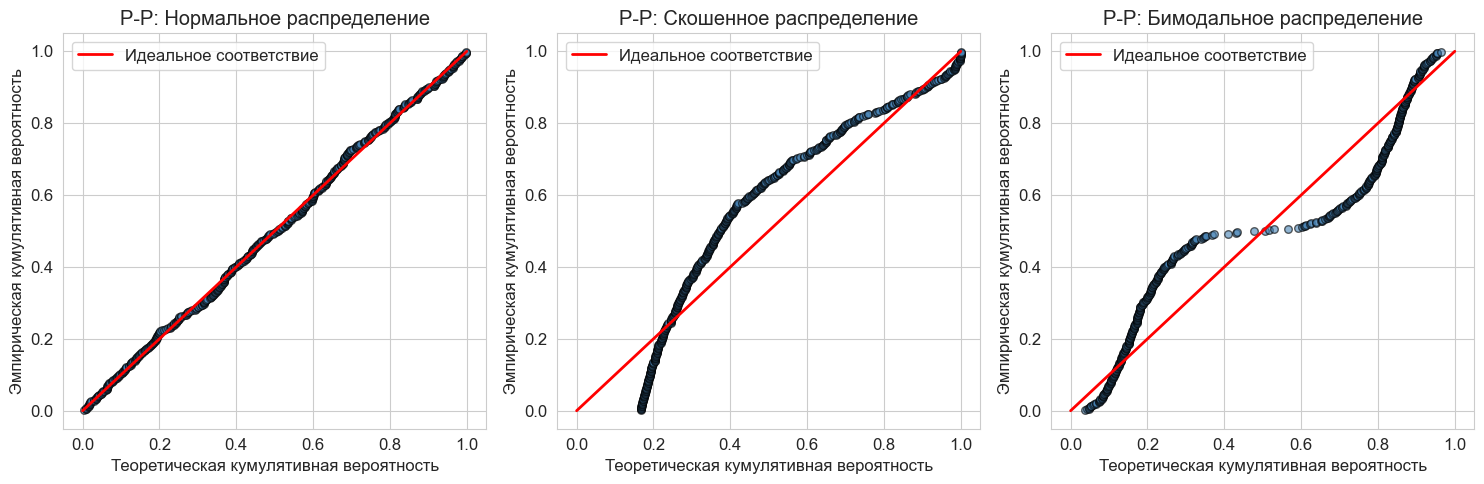

In [7]:
def plot_pp(data, title, ax):
    """
    Строит P-P plot для проверки нормальности.
    
    Параметры:
    ----------
    data : array-like
        Данные для анализа
    title : str
        Заголовок графика
    ax : matplotlib.axes.Axes
        Объект осей для построения
    """
    # Сортируем данные
    sorted_data = np.sort(data)
    n = len(sorted_data)
    
    # Эмпирические вероятности (позиции в упорядоченной выборке)
    empirical_prob = np.arange(1, n + 1) / (n + 1)
    
    # Теоретические вероятности (CDF нормального распределения)
    mu, sigma = np.mean(data), np.std(data)
    theoretical_prob = stats.norm.cdf(sorted_data, mu, sigma)
    
    # Построение P-P plot
    ax.scatter(theoretical_prob, empirical_prob, alpha=0.6, 
               color='steelblue', edgecolor='black', s=30)
    
    # Диагональная линия (идеальное соответствие)
    ax.plot([0, 1], [0, 1], 'r-', linewidth=2, label='Идеальное соответствие')
    
    ax.set_title(title)
    ax.set_xlabel('Теоретическая кумулятивная вероятность')
    ax.set_ylabel('Эмпирическая кумулятивная вероятность')
    ax.legend(loc='upper left')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)


# Построение P-P plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_pp(data_normal, 'P-P: Нормальное распределение', axes[0])
plot_pp(data_skewed, 'P-P: Скошенное распределение', axes[1])
plot_pp(data_bimodal, 'P-P: Бимодальное распределение', axes[2])

plt.tight_layout()
plt.show()

## 1.4 Box Plot (Диаграмма размаха / Ящик с усами)

**Суть метода:** показывает медиану, квартили и потенциальные выбросы.
Для нормального распределения характерна симметричность.

**На что смотреть:**
- Медиана (линия внутри ящика) должна быть примерно посередине
- Усы должны быть примерно одинаковой длины
- Количество выбросов с обеих сторон должно быть сопоставимым

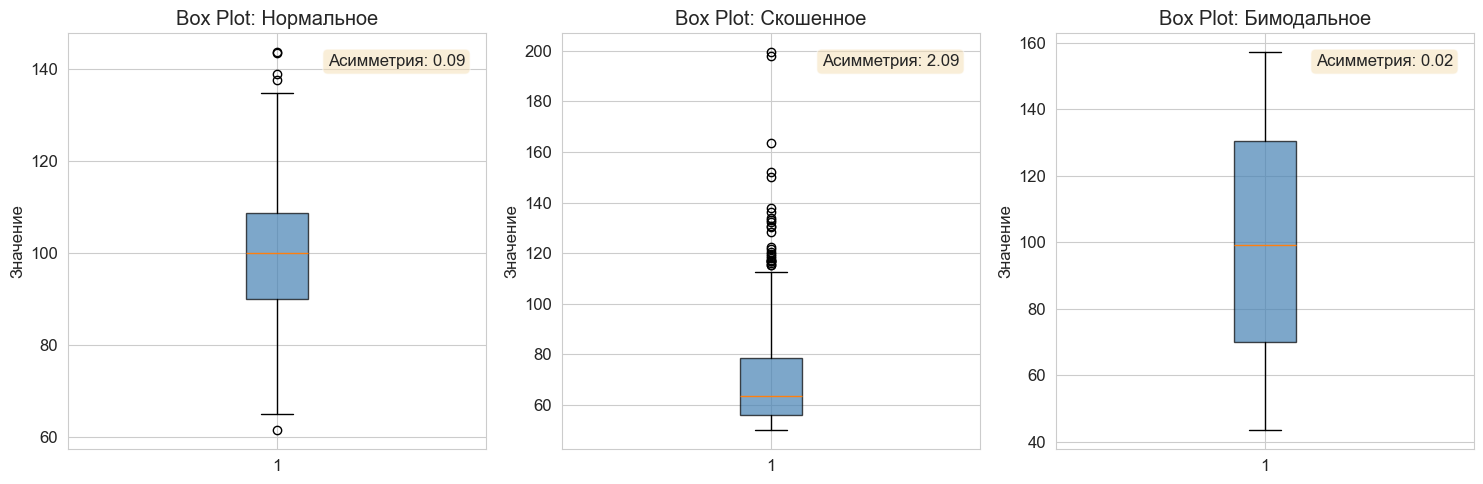

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (col_name, data) in zip(axes, df.items()):
    bp = ax.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][0].set_alpha(0.7)
    
    ax.set_title(f'Box Plot: {col_name}')
    ax.set_ylabel('Значение')
    
    # Добавим информацию о асимметрии
    skewness = stats.skew(data)
    ax.text(0.95, 0.95, f'Асимметрия: {skewness:.2f}', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 1.5 Комбинированная визуализация (seaborn)

Библиотека seaborn предоставляет удобный способ построения гистограммы с оценкой плотности ядра (KDE) одной командой.

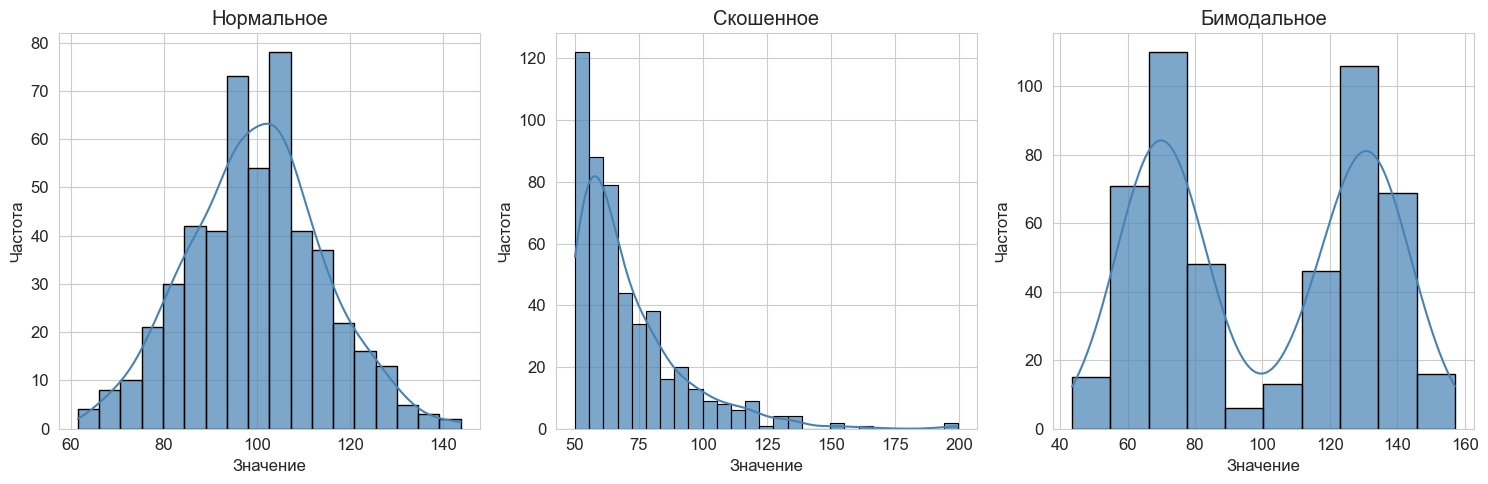

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (col_name, data) in zip(axes, df.items()):
    # histplot с KDE даёт хорошую визуализацию
    sns.histplot(data, kde=True, ax=ax, color='steelblue', 
                 edgecolor='black', alpha=0.7)
    ax.set_title(f'{col_name}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

## Сводка: визуальные методы

| Метод | Преимущества | Недостатки | Когда использовать |
|-------|-------------|------------|-------------------|
| Гистограмма | Интуитивно понятна | Зависит от числа бинов | Первичный осмотр данных |
| Q-Q Plot | Очень информативен, показывает тип отклонения | Требует опыта интерпретации | Основной визуальный метод |
| P-P Plot | Чувствителен к центру распределения | Менее информативен для хвостов | Когда важен центр распределения |
| Box Plot | Показывает выбросы и симметрию | Не показывает форму распределения | Выявление асимметрии и выбросов |


# ЧАСТЬ 2: СТАТИСТИЧЕСКИЕ ТЕСТЫ

Статистические тесты дают формальный ответ на вопрос о нормальности в виде $p-\text{value}$. Однако у них есть важные ограничения!

**Общая логика тестов:**
- $\rm{H_{0}}$ (нулевая гипотеза): данные распределены нормально
- $\rm{H_{1}}$ (альтернативная гипотеза): данные НЕ распределены нормально
- Если $p-\text{value} < \alpha$ (обычно 0.05), отвергаем $\rm{H_{0}}$ → данные "ненормальны"
 
**Важно понимать:**
- При большой выборке тесты отвергают $\rm{H_{0}}$ даже при незначительных отклонениях
- При малой выборке тесты могут не выявить существенные отклонения
- Всегда комбинируйте с визуальным анализом!

## 2.1 Тест Шапиро-Уилка (Shapiro-Wilk)

**Суть:** сравнивает упорядоченные значения выборки с ожидаемыми значениями для нормального распределения.

**Условия применения:**
- Размер выборки: **3 ≤ n ≤ 5000** (в scipy)
- Оптимально работает при **n < 50**
- Считается одним из самых мощных тестов для малых выборок

**Интерпретация:**
- W близко к 1 → данные близки к нормальному распределению
- p-value < 0.05 → отвергаем гипотезу о нормальности

In [10]:
def shapiro_wilk_test(data, name, alpha=0.05):
    """
    Выполняет тест Шапиро-Уилка и выводит результаты.
    
    Параметры:
    ----------
    data : array-like
        Данные для тестирования
    name : str
        Название набора данных
    alpha : float
        Уровень значимости (по умолчанию 0.05)
    """
    stat, p_value = stats.shapiro(data)
    
    print(f"{'='*50}")
    print(f"Тест Шапиро-Уилка: {name}")
    print(f"{'='*50}")
    print(f"Статистика W = {stat:.4f}")
    print(f"p-value = {p_value:.4e}")
    print(f"Уровень значимости α = {alpha}")
    print()
    
    if p_value > alpha:
        print(f"✓ p-value ({p_value:.4f}) > α ({alpha})")
        print("  Нет оснований отвергать гипотезу о нормальности")
    else:
        print(f"✗ p-value ({p_value:.4e}) < α ({alpha})")
        print("  Гипотеза о нормальности отвергается")
    print()


# Применяем тест ко всем наборам данных
shapiro_wilk_test(data_normal, "Нормальное распределение", alpha=0.05)
shapiro_wilk_test(data_skewed, "Скошенное распределение", alpha=0.05)
shapiro_wilk_test(data_bimodal, "Бимодальное распределение", alpha=0.05)

Тест Шапиро-Уилка: Нормальное распределение
Статистика W = 0.9974
p-value = 6.3297e-01
Уровень значимости α = 0.05

✓ p-value (0.6330) > α (0.05)
  Нет оснований отвергать гипотезу о нормальности

Тест Шапиро-Уилка: Скошенное распределение
Статистика W = 0.8013
p-value = 2.7048e-24
Уровень значимости α = 0.05

✗ p-value (2.7048e-24) < α (0.05)
  Гипотеза о нормальности отвергается

Тест Шапиро-Уилка: Бимодальное распределение
Статистика W = 0.8862
p-value = 9.6528e-19
Уровень значимости α = 0.05

✗ p-value (9.6528e-19) < α (0.05)
  Гипотеза о нормальности отвергается



## 2.2 Тест Колмогорова-Смирнова (Kolmogorov-Smirnov)

**Суть:** измеряет максимальное расстояние между эмпирической функцией распределения (ECDF) выборки и теоретической CDF.

**Условия применения:**
- Размер выборки: **n ≥ 20** (рекомендуется)
- Параметры распределения должны быть известны заранее
- **ВАЖНО:** если параметры оцениваются по выборке, тест становится консервативным!

**Особенности:**
- Универсальный тест (можно проверять любое распределение)
- Менее мощный, чем Шапиро-Уилка для проверки нормальности
- Чувствителен к различиям в центре распределения

In [11]:
def ks_test(data, name, alpha=0.05):
    """
    Выполняет тест Колмогорова-Смирнова и выводит результаты.
    
    Параметры:
    ----------
    data : array-like
        Данные для тестирования
    name : str
        Название набора данных
    alpha : float
        Уровень значимости
    """
    # Оцениваем параметры нормального распределения по выборке
    mu, sigma = np.mean(data), np.std(data)
    
    # Выполняем тест (сравниваем с N(mu, sigma))
    stat, p_value = stats.kstest(data, 'norm', args=(mu, sigma))
    
    print(f"{'='*50}")
    print(f"Тест Колмогорова-Смирнова: {name}")
    print(f"{'='*50}")
    print(f"Параметры: μ = {mu:.2f}, σ = {sigma:.2f}")
    print(f"Статистика D = {stat:.4f}")
    print(f"p-value = {p_value:.4e}")
    print()
    
    if p_value > alpha:
        print(f"✓ p-value ({p_value:.4f}) > α ({alpha})")
        print("  Нет оснований отвергать гипотезу о нормальности")
    else:
        print(f"✗ p-value ({p_value:.4e}) < α ({alpha})")
        print("  Гипотеза о нормальности отвергается")
    print()


# Применяем тест
ks_test(data_normal, "Нормальное распределение", alpha=0.05)
ks_test(data_skewed, "Скошенное распределение", alpha=0.05)
ks_test(data_bimodal, "Бимодальное распределение", alpha=0.05)

Тест Колмогорова-Смирнова: Нормальное распределение
Параметры: μ = 99.80, σ = 14.38
Статистика D = 0.0293
p-value = 7.7335e-01

✓ p-value (0.7734) > α (0.05)
  Нет оснований отвергать гипотезу о нормальности

Тест Колмогорова-Смирнова: Скошенное распределение
Параметры: μ = 70.49, σ = 21.21
Статистика D = 0.1673
p-value = 1.0674e-12

✗ p-value (1.0674e-12) < α (0.05)
  Гипотеза о нормальности отвергается

Тест Колмогорова-Смирнова: Бимодальное распределение
Параметры: μ = 99.97, σ = 31.72
Статистика D = 0.1608
p-value = 9.2233e-12

✗ p-value (9.2233e-12) < α (0.05)
  Гипотеза о нормальности отвергается



### Примечание о тесте Колмогорова-Смирнова

Когда параметры (μ, σ) оцениваются по той же выборке, критические значения теста занижаются. Для корректной проверки используйте модификацию Лиллиефорса или тест `scipy.stats.lilliefors` из библиотеки `statsmodels`.

In [13]:
# Тест Лиллиефорса (модификация K-S для оцененных параметров)
from statsmodels.stats.diagnostic import lilliefors

def lilliefors_test(data, name, alpha=0.05):
    """
    Выполняет тест Лиллиефорса и выводит результаты.
    """
    stat, p_value = lilliefors(data, dist='norm')
    
    print(f"{'='*50}")
    print(f"Тест Лиллиефорса: {name}")
    print(f"{'='*50}")
    print(f"Статистика D = {stat:.4f}")
    print(f"p-value = {p_value:.4f}")
    print()
    
    if p_value > alpha:
        print(f"✓ Нет оснований отвергать гипотезу о нормальности")
    else:
        print(f"✗ Гипотеза о нормальности отвергается")
    print()


lilliefors_test(data_normal, "Нормальное распределение", alpha=0.05)
lilliefors_test(data_skewed, "Скошенное распределение", alpha=0.05)
lilliefors_test(data_bimodal, "Бимодальное распределение", alpha=0.05)

Тест Лиллиефорса: Нормальное распределение
Статистика D = 0.0295
p-value = 0.4403

✓ Нет оснований отвергать гипотезу о нормальности

Тест Лиллиефорса: Скошенное распределение
Статистика D = 0.1675
p-value = 0.0010

✗ Гипотеза о нормальности отвергается

Тест Лиллиефорса: Бимодальное распределение
Статистика D = 0.1606
p-value = 0.0010

✗ Гипотеза о нормальности отвергается



## 2.3 Тест Д'Агостино-Пирсона (D'Agostino-Pearson)

**Суть:** комбинирует тесты на асимметрию (skewness) и эксцесс (kurtosis) в единый omnibus-тест.

**Условия применения:**
- Размер выборки: **n ≥ 20** (строго)
- Рекомендуется **n ≥ 50** для надёжных результатов

**Преимущества:**
- Хорошо выявляет отклонения, связанные с асимметрией и формой хвостов
- Работает для средних и больших выборок

**Что тестируется:**
- Асимметрия (skewness): для нормального распределения ≈ 0
- Эксцесс (kurtosis): для нормального распределения ≈ 0

In [14]:
def dagostino_test(data, name, alpha=0.05):
    """
    Выполняет тест Д'Агостино-Пирсона и выводит результаты.
    """
    if len(data) < 20:
        print(f"⚠ Тест Д'Агостино требует n ≥ 20, в выборке n = {len(data)}")
        return
    
    stat, p_value = stats.normaltest(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    print(f"{'='*50}")
    print(f"Тест Д'Агостино-Пирсона: {name}")
    print(f"{'='*50}")
    print(f"Асимметрия (skewness) = {skewness:.4f}")
    print(f"Эксцесс (kurtosis) = {kurtosis:.4f}")
    print(f"Статистика K² = {stat:.4f}")
    print(f"p-value = {p_value:.4e}")
    print()
    
    if p_value > alpha:
        print(f"✓ Нет оснований отвергать гипотезу о нормальности")
    else:
        print(f"✗ Гипотеза о нормальности отвергается")
    print()


dagostino_test(data_normal, "Нормальное распределение", alpha=0.05)
dagostino_test(data_skewed, "Скошенное распределение", alpha=0.05)
dagostino_test(data_bimodal, "Бимодальное распределение", alpha=0.05)

Тест Д'Агостино-Пирсона: Нормальное распределение
Асимметрия (skewness) = 0.0934
Эксцесс (kurtosis) = -0.0516
Статистика K² = 0.7529
p-value = 6.8629e-01

✓ Нет оснований отвергать гипотезу о нормальности

Тест Д'Агостино-Пирсона: Скошенное распределение
Асимметрия (skewness) = 2.0941
Эксцесс (kurtosis) = 6.4056
Статистика K² = 237.9953
p-value = 2.0891e-52

✗ Гипотеза о нормальности отвергается

Тест Д'Агостино-Пирсона: Бимодальное распределение
Асимметрия (skewness) = 0.0208
Эксцесс (kurtosis) = -1.6137
Статистика K² = 3137.6764
p-value = 0.0000e+00

✗ Гипотеза о нормальности отвергается



## 2.4 Тест Андерсона-Дарлинга (Anderson-Darling)

**Суть:** модификация теста Колмогорова-Смирнова с бо́льшим весом для хвостов распределения.

**Условия применения:**
- Размер выборки: **n ≥ 8**
- Лучше работает при **n ≥ 20**

**Преимущества:**
- Более мощный, чем K-S тест
- Лучше выявляет отклонения в хвостах
- Предоставляет критические значения для разных уровней значимости

In [15]:
def anderson_test(data, name):
    """
    Выполняет тест Андерсона-Дарлинга и выводит результаты.
    """
    result = stats.anderson(data, dist='norm')
    
    print(f"{'='*50}")
    print(f"Тест Андерсона-Дарлинга: {name}")
    print(f"{'='*50}")
    print(f"Статистика A² = {result.statistic:.4f}")
    print()
    print("Критические значения:")
    print("-" * 40)
    
    for i, (cv, sl) in enumerate(zip(result.critical_values, result.significance_level)):
        # Сравниваем статистику с критическим значением
        if result.statistic < cv:
            verdict = "✓ Норм."
        else:
            verdict = "✗ Не норм."
        print(f"  α = {sl:5.1f}%: крит.знач. = {cv:.4f}  {verdict}")
    print()


anderson_test(data_normal, "Нормальное распределение")
anderson_test(data_skewed, "Скошенное распределение")
anderson_test(data_bimodal, "Бимодальное распределение")

Тест Андерсона-Дарлинга: Нормальное распределение
Статистика A² = 0.2736

Критические значения:
----------------------------------------
  α =  15.0%: крит.знач. = 0.5710  ✓ Норм.
  α =  10.0%: крит.знач. = 0.6510  ✓ Норм.
  α =   5.0%: крит.знач. = 0.7810  ✓ Норм.
  α =   2.5%: крит.знач. = 0.9110  ✓ Норм.
  α =   1.0%: крит.знач. = 1.0830  ✓ Норм.

Тест Андерсона-Дарлинга: Скошенное распределение
Статистика A² = 25.5564

Критические значения:
----------------------------------------
  α =  15.0%: крит.знач. = 0.5710  ✗ Не норм.
  α =  10.0%: крит.знач. = 0.6510  ✗ Не норм.
  α =   5.0%: крит.знач. = 0.7810  ✗ Не норм.
  α =   2.5%: крит.знач. = 0.9110  ✗ Не норм.
  α =   1.0%: крит.знач. = 1.0830  ✗ Не норм.

Тест Андерсона-Дарлинга: Бимодальное распределение
Статистика A² = 24.7888

Критические значения:
----------------------------------------
  α =  15.0%: крит.знач. = 0.5710  ✗ Не норм.
  α =  10.0%: крит.знач. = 0.6510  ✗ Не норм.
  α =   5.0%: крит.знач. = 0.7810  ✗ Не норм.
  

## 2.5 Тест Жарка-Бера (Jarque-Bera)

**Суть:** проверяет, соответствуют ли асимметрия и эксцесс выборки значениям нормального распределения (0 и 0 соответственно).

**Условия применения:**
- Размер выборки: **n ≥ 30** (асимптотический тест)
- Лучше работает при **n > 100**

**Особенности:**
- Часто используется в эконометрике
- Основан на χ² распределении с 2 степенями свободы
- Менее мощный при малых выборках

In [16]:
def jarque_bera_test(data, name, alpha=0.05):
    """
    Выполняет тест Жарка-Бера и выводит результаты.
    """
    stat, p_value = stats.jarque_bera(data)
    
    print(f"{'='*50}")
    print(f"Тест Жарка-Бера: {name}")
    print(f"{'='*50}")
    print(f"Статистика JB = {stat:.4f}")
    print(f"p-value = {p_value:.4e}")
    print()
    
    if p_value > alpha:
        print(f"✓ Нет оснований отвергать гипотезу о нормальности")
    else:
        print(f"✗ Гипотеза о нормальности отвергается")
    print()


jarque_bera_test(data_normal, "Нормальное распределение")
jarque_bera_test(data_skewed, "Скошенное распределение")
jarque_bera_test(data_bimodal, "Бимодальное распределение")

Тест Жарка-Бера: Нормальное распределение
Статистика JB = 0.7827
p-value = 6.7615e-01

✓ Нет оснований отвергать гипотезу о нормальности

Тест Жарка-Бера: Скошенное распределение
Статистика JB = 1220.2718
p-value = 1.0504e-265

✗ Гипотеза о нормальности отвергается

Тест Жарка-Бера: Бимодальное распределение
Статистика JB = 54.2857
p-value = 1.6293e-12

✗ Гипотеза о нормальности отвергается



## Сводная таблица: выбор теста нормальности

| Тест | Размер выборки | Мощность | Особенности |
|------|---------------|----------|-------------|
| **Шапиро-Уилка** | 3-5000 (оптимально < 50) | Высокая | Лучший для малых выборок |
| **Лиллиефорса** | ≥ 20 | Средняя | K-S с оценёнными параметрами |
| **Д'Агостино-Пирсона** | ≥ 20 (лучше ≥ 50) | Высокая | Проверяет skewness и kurtosis |
| **Андерсона-Дарлинга** | ≥ 8 (лучше ≥ 20) | Высокая | Чувствителен к хвостам |
| **Жарка-Бера** | ≥ 30 (лучше > 100) | Средняя | Популярен в эконометрике |
| **Колмогорова-Смирнова** | ≥ 20 | Низкая | Универсальный, но слабый |

# ЧАСТЬ 3: ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ

## 3.1 Алгоритм выбора теста

```
Размер выборки n?
│
├── n < 20:  → Шапиро-Уилка + визуальный анализ
│
├── 20 ≤ n < 50:  → Шапиро-Уилка + Д'Агостино
│
└── n ≥ 50:  → Любой тест (рекомендуется несколько)
```

## 3.2 Что делать, если данные ненормальны?

1. **Трансформация данных:**
   - Логарифмическая: `np.log(data)` — для правой асимметрии
   - Корневая: `np.sqrt(data)` — умеренная коррекция
   - Box-Cox: `stats.boxcox(data)` — автоматический подбор

2. **Непараметрические методы:**
   - Вместо t-теста → критерий Манна-Уитни
   - Вместо ANOVA → критерий Краскела-Уоллиса
   - Вместо корреляции Пирсона → корреляция Спирмена

3. **Робастные методы:**
   - Использовать медиану вместо среднего
   - Применять робастную регрессию

## 3.3 Пример трансформации данных

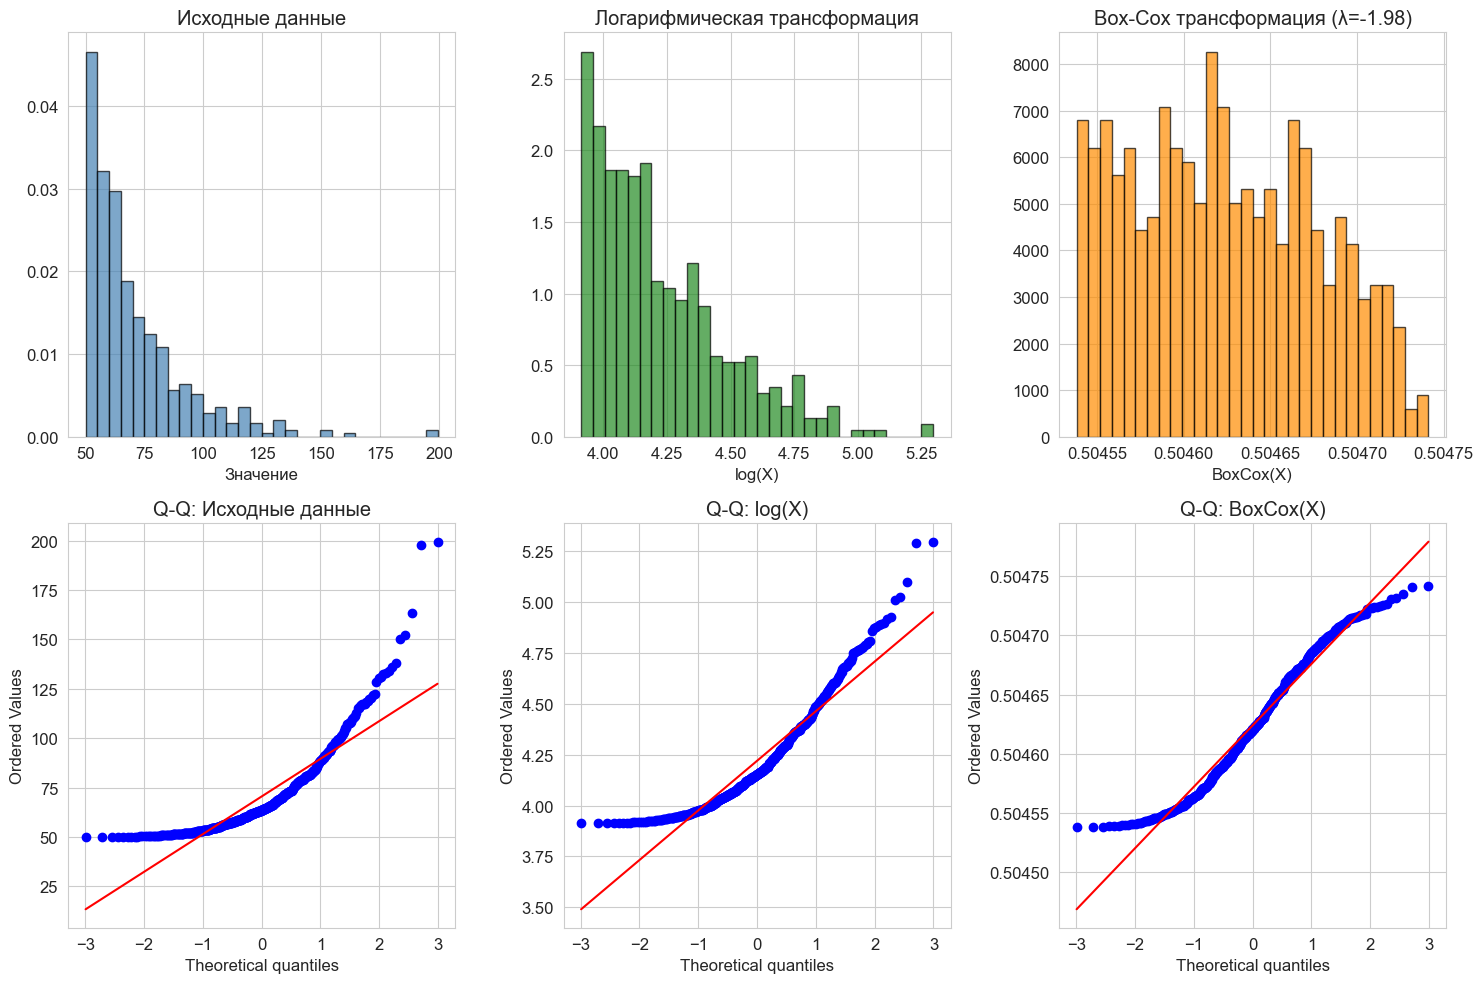

In [17]:
# Попробуем нормализовать скошенные данные
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Исходные данные
ax = axes[0, 0]
ax.hist(data_skewed, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_title('Исходные данные')
ax.set_xlabel('Значение')

# Q-Q исходных данных
ax = axes[1, 0]
stats.probplot(data_skewed, plot=ax)
ax.set_title('Q-Q: Исходные данные')

# Логарифмическая трансформация
log_data = np.log(data_skewed)
ax = axes[0, 1]
ax.hist(log_data, bins=30, density=True, alpha=0.7, color='forestgreen', edgecolor='black')
ax.set_title('Логарифмическая трансформация')
ax.set_xlabel('log(X)')

ax = axes[1, 1]
stats.probplot(log_data, plot=ax)
ax.set_title('Q-Q: log(X)')

# Box-Cox трансформация
boxcox_data, lambda_param = stats.boxcox(data_skewed)
ax = axes[0, 2]
ax.hist(boxcox_data, bins=30, density=True, alpha=0.7, color='darkorange', edgecolor='black')
ax.set_title(f'Box-Cox трансформация (λ={lambda_param:.2f})')
ax.set_xlabel('BoxCox(X)')

ax = axes[1, 2]
stats.probplot(boxcox_data, plot=ax)
ax.set_title('Q-Q: BoxCox(X)')

plt.tight_layout()
plt.show()


In [18]:
# Тесты после трансформации
print("\nТест Шапиро-Уилка после трансформации:")
print(f"  Исходные данные: p = {stats.shapiro(data_skewed)[1]:.4e}")
print(f"  Log-трансформация: p = {stats.shapiro(log_data)[1]:.4f}")
print(f"  Box-Cox: p = {stats.shapiro(boxcox_data)[1]:.4f}")



Тест Шапиро-Уилка после трансформации:
  Исходные данные: p = 2.7048e-24
  Log-трансформация: p = 0.0000
  Box-Cox: p = 0.0000


# ЧАСТЬ 4: УПРАЖНЕНИЯ ДЛЯ САМОСТОЯТЕЛЬНОЙ РАБОТЫ

## Упражнение 1
Загрузите данные о пассажирах Титаника и проверьте нормальность распределения возраста (`Age`).

## Упражнение 2
Сгенерируйте выборку из равномерного распределения (uniform) и проверьте её на нормальность. Какие тесты лучше выявляют отклонение?

## Упражнение 3
Исследуйте, как размер выборки влияет на результаты тестов:
- Сгенерируйте нормальные выборки размером 10, 30, 100, 500, 5000
- Примените все тесты и сравните p-values

## Упражнение 4
Добавьте несколько выбросов в нормально распределённые данные и исследуйте, какие тесты наиболее чувствительны к выбросам.
